In [1]:
#import relevant packages
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

Using TensorFlow backend.


In [2]:
t=pd.read_csv('airline_sentiment.csv')
t.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
import nltk
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gceran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-zA-Z]+',' ',text)
    words = text.split()
    words2=[w for w in words if (w not in stop)]
    #words3=[ps.stem(w) for w in words]
    words4=' '.join(words2)
    return(words4)

In [5]:
t['text'] = t['text'].apply(preprocess)

In [6]:
from collections import Counter
counts = Counter()
for i,review in enumerate(t['text']):
    counts.update(review.split())

In [7]:
words = sorted(counts, key=counts.get, reverse=True)
words[0:10]

['united',
 'flight',
 'usairways',
 'americanair',
 'southwestair',
 'jetblue',
 'get',
 'cancelled',
 'thanks',
 'service']

In [8]:
chars = words
nb_chars = len(words)
nb_chars

12532

In [9]:
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

In [ ]:
int_to_word

In [11]:
mapped_reviews = []
for review in t['text']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

In [12]:
print('Original text:',t.loc[0]['text'])
print('Mapped text:',mapped_reviews[0])

Original text: virginamerica plus added commercials experience tacky
Mapped text: [44, 450, 1142, 2233, 100, 5429]


In [13]:
t.loc[0:1]['text']

0    virginamerica plus added commercials experienc...
1    virginamerica really aggressive blast obnoxiou...
Name: text, dtype: object

In [14]:
mapped_reviews[0:2]

[[44, 450, 1142, 2233, 100, 5429],
 [44, 57, 3036, 3845, 3846, 815, 3037, 3847, 19, 366, 2234]]

In [15]:
length_sent = []
for i in range(len(mapped_reviews)):
  length_sent.append(len(mapped_reviews[i]))
max(length_sent)

26

In [16]:
sequence_length = max(length_sent)
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)

In [17]:
X.shape

(11541, 26)

In [18]:
y=t['airline_sentiment'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=10)
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

# Sentiment classification using LSTM

In [20]:
from keras.layers import LSTM

In [21]:
embedding_vecor_length=32
max_review_length=26
model = Sequential()
model.add(Embedding(input_dim=12533, output_dim=32, input_length = 26))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 32)            401056    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                11680     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 412,818
Trainable params: 412,818
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
W = model.layers[1].get_weights()[0]
U = model.layers[1].get_weights()[1]
b = model.layers[1].get_weights()[2]
print(W.shape,U.shape,b.shape)

(32, 160) (40, 160) (160,)


In [23]:
units = 40
W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

In [24]:
W.shape

(32, 160)

In [25]:
73*160

11680

In [26]:
history = model.fit(X_train, y_train2, validation_data=(X_test, y_test2), epochs=10, batch_size=32)

/Users/gceran/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8078 samples, validate on 3463 samples
Epoch 1/10
8078/8078 [==============================] - 25s 3ms/step - loss: 0.3662 - accuracy: 0.8517 - val_loss: 0.2327 - val_accuracy: 0.9105
Epoch 2/10
8078/8078 [==============================] - 21s 3ms/step - loss: 0.1465 - accuracy: 0.9448 - val_loss: 0.2120 - val_accuracy: 0.9215
Epoch 3/10
8078/8078 [==============================] - 20s 3ms/step - loss: 0.0780 - accuracy: 0.9764 - val_loss: 0.2317 - val_accuracy: 0.9096
Epoch 4/10
8078/8078 [==============================] - 21s 3ms/step - loss: 0.0495 - accuracy: 0.9853 - val_loss: 0.3185 - val_accuracy: 0.9076
Epoch 5/10
8078/8078 [==============================] - 20s 3ms/step - loss: 0.0328 - accuracy: 0.9910 - val_loss: 0.3666 - val_accuracy: 0.9102
Epoch 6/10
8078/8078 [==============================] - 20s 3ms/step - loss: 0.0223 - accuracy: 0.9939 - val_loss: 0.3856 - val_accuracy: 0.9059
Epoch 7/10
8078/8078 [==============================] - 20s 2ms/step - loss: 0.016

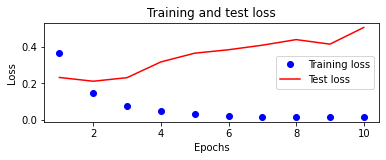

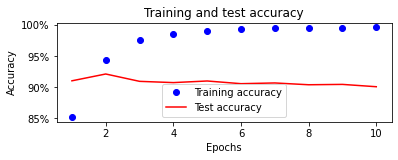

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.ticker as mtick
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid(False)
plt.show()